In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
import math
import pickle

from keras.models import Sequential, model_from_json
from keras import layers
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

Check if Keras is using GPU.

```device:GPU:0``` means that Keras is running a GPU (see [here](https://www.tensorflow.org/programmers_guide/using_gpu)).

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

If any problems, may want to get list of local tensorflow devices (I'm a little puzzled that CPU is showing up, since it looks like I've only installed tensorflow GPU).

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5896020367118571125
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13688432107387358350
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [9]:
# data_dir = '/Users/sambarrows/Dropbox/Stats/Projects/predict311'
data_dir = '/home/ubuntu/data'

# Overview

NYC311 provides access to non-emergency City services and information about City government programs. In this dataset, the number of calls received by NYC's 311 service in 10 minute intervals are recorded. The number of calls is also broken down by the responding agency. 

The original data goes back to 2010. initial exploration of the data, however, indicated that the number of calls received has changed substantially in this period. Specifically, the volume of calls increased substantially during 2015 and has remained at a high level since. I therefore use only data from 2016 and 2017.

I will build a model that takes as input data from the recent past and predicts the number of calls during a 10 minute interval one week in the future. I chose to divide my data into 10 minute intervals in order to give me sufficient time steps to work with. 

# Read, parse, and explore the data

## Read data from csv

In [10]:
fname = os.path.join(data_dir, 'calldat1617.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:len(lines)-1]    # drop the tenmin colum
                                 # also, for some reason final element in line an empty string so drop that too
lines[len(lines)-1]
print(header)
print(len(lines))

['tenmin', 'DEP', 'DOB', 'DOF', 'DOHMH', 'DOT', 'DPR', 'DSNY', 'HPD', 'NYPD', 'TLC', 'other', 'total']
105264


## Parse the data

In [11]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [12]:
float_data[:2]

array([[ 0.,  0.,  0., 53.,  0.,  0.,  0.,  3., 19.,  0.,  0., 75.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  2., 26.,  0.,  0., 30.]])

## Read in as pandas to check all looks ok

In [18]:
df_check = pd.read_csv(fname)
df_check.head(2)

,tenmin,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other,total
0,2016-01-01-00-00,0.0,0.0,0.0,53.0,0.0,0.0,0.0,3.0,19.0,0.0,0.0,75.0
1,2016-01-01-00-10,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,26.0,0.0,0.0,30.0


## Plot the data

I already did some exploratory plots in creating the dataset, but let's add a couple as a quick sanity check.

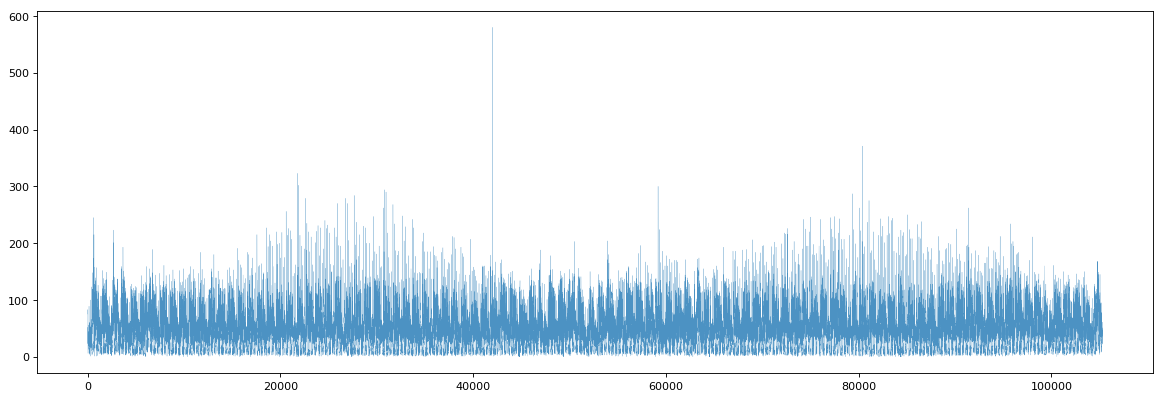

In [7]:
# plot the entire time series
tots = float_data[:, 11]  # total calls in interval
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(range(len(tots)), tots, alpha=.8, linewidth=.2)
plt.show()

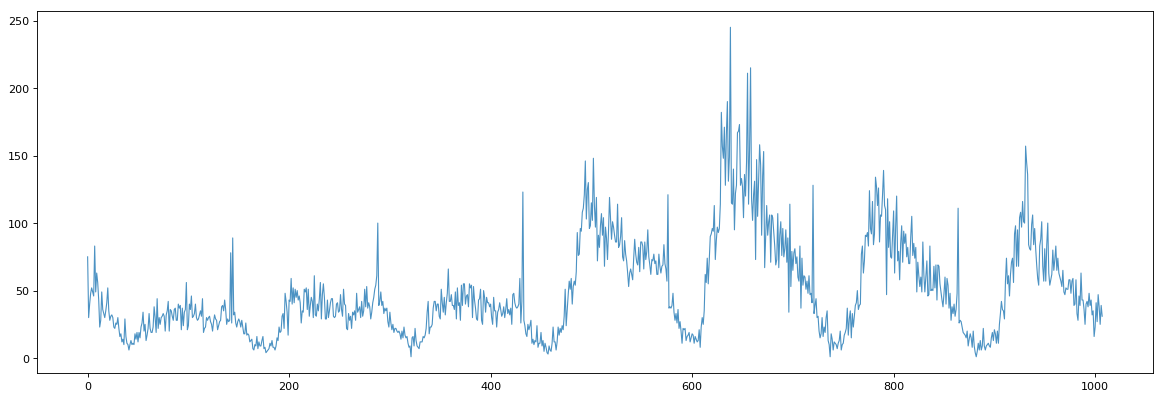

In [8]:
# plot the first week
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(range(6*24*7), tots[:6*24*7], alpha=.8, linewidth=1.)
plt.show()

# Use an RNN for time series prediction

## Overview of approach

For each sample (observation) in the training or validation set, I will take ```loockback``` time steps (in this case, 6 week's timesteps) as my inputs for that sample. Note that each time step (each input) has multiple features (the number of calls to each agencies). 

I then look forward ```delay``` timesteps (in this case, 1 week's timesteps) for my single target (or prediction): the total number of calls in a 10 minute intervals. This is therefore a many-to-one architecture.

I will fit my model for all observations in the training set and validation set for which I am amble to look both backward and forward a sufficient number of timesteps.

## Preprocess data

### Train/dev/test sets

In [13]:
len(float_data) - 20000*2

65264

I will use out of time validation and test sets. That is, I will train my model on the first 65,264 timesteps, validate on the next 20,000 timesteps, and test on the final 20,000 timesteps. 

In [14]:
print 'First training timestep:', lines[0][:16]
print 'Last training timestep:', lines[len(float_data) - 20000*2][:16]
print 'Last vaidation timestep:', lines[len(float_data) - 20000][:16]
print 'Last test timestep:', lines[len(float_data)-1][:16]

First training timestep: 2016-01-01-00-00
Last training timestep: 2017-03-29-05-20
Last vaidation timestep: 2017-08-15-02-40
Last test timestep: 2017-12-31-23-50


### Normalize the data

I will normalize the data by substracting the mean of each timeseries and dividing by the standard deviation. I will compute the mean and stanard deviation on my training data only: the first 65,264 timesteps.

In [15]:
mean = float_data[:65264].mean(axis=0)
float_data -= mean
std = float_data[:65264].std(axis=0)
float_data /= std

## Define and instantiate generators

### Define generator yielding timeseries samples and their targets

The samples (data points) in the dataset are highly redundant (e.g. sample N and sample N + 1 will have most of their timesteps in common). It would be very wasteful to explicitly allocate every sample. Instead, I will define a generator to generate the samples on the fly using the original data.

The generator below yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

We iterate over the following generator once for each mini-batch of timesteps. 

Within this generator, we then loop over every timestep for which it is viable to make a prediction (ie enough timesteps before and after) and find the early timesteps to include as inputs for that timesteps' prediction and the target for that timestep.

In [16]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    # code before "while 1" only executes the first time execute generator function
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback   # first timestep for which make prediction is lookback steps after min_index
    while 1:    # executes following code each time iterate over generator (ie with each .next()/for each mini-batch)
        if shuffle:   
            # draw a random sample of rows
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:   
            # update i and row values
            if i + batch_size >= max_index: # if batch would go beyond max_index...
                i = min_index + lookback    # ...revert to initial i value
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)       # i increases by len(rows) each iteration over the genetor
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):    # for each timestampe in mini-batch
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## Prepare the training, validation, and test generators

### Confirm number timesteps to look backward for inputs and forward for targets

In [17]:
# number timesteps to look back 6 weeks
print "6 week's timesteps:", 6*24*7*6
print "1 week's timesteps:", 6*24*7

6 week's timesteps: 6048
1 week's timesteps: 1008


In [18]:
# # confirm that I am selecting timestampe exactly one week ahead
# float_data_check = np.zeros((len(lines), len(header) - 1))
# dates = []
# for i, line in enumerate(lines):
#     values = [float(x) for x in line.split(',')[1:]]
#     dates.append(line.split(',')[0])
#     float_data_check[i, :] = values
# print len(float_data_check)
# print len(dates)
# print dates[0]
# print dates[0 + 6*24*7]

### Instantiate generators

Now I'll use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 

In [26]:
lookback = 6*24*7*6   # look back 6 weeks
delay = 6*24*7        # predict 1 week ahead
max_training = 65264
step=1
batch_size=128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=max_training,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=max_training+1,
                    max_index=max_training+20000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=max_training+20001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = ((max_training+20000) - (max_training+1) - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - (max_training+20001) - lookback) // batch_size

### Explore output of the generators

***!!! Important to comment this out and re-create generators before fitting model. Need to make sure that haven't started iterating through generators already when fitting model. !!!***

Let's explore some of this output to make sure we're clear what it's doing. 

First, let's take a look at the output of train_gen with a batch size of 1 (which I adjust above):

In [119]:
# a = train_gen.next()
# print 'Each iteration of generator outputs a tuple of 2 elements:'
# print type(a)
# print len(a)
# print

# print 'The 2nd element of the tuple is the target:'
# print type(a[1])
# print a[1].shape
# print a[1]
# print

# print 'The 1st element of the tuple gives feature values for each timestep we will input to the model.'
# print 'It is a 3d array: a list of length 1, containing a 2d array where rows are timestamps' 
# print 'and columns are features' 
# print type(a[0])
# print a[0].shape

Each iteration of generator outputs a tuple of 2 elements:
<type 'tuple'>
2

The 2nd element of the tuple is the target:
<type 'numpy.ndarray'>
(1,)
[-0.56092767]

The 1st element gives feature values for each timestep we will input to the model.
It is a 3d array: a list of length 1, containing a 2d array where rows are timestamps
and columns are features
<type 'numpy.ndarray'>
(1, 1440, 12)


Now, let's take a look at the oupput of train_gen with bath size of 128 (I adjusting the batch size above
and create the generators again, but not run the cell above).

In [125]:
# a = train_gen.next()
# print 'Each iteration of generator again outputs a tuple of 2 elements:'
# print type(a)
# print len(a)
# print

# print 'The 2nd element of the tuple is the targets. It is an array of'
# print 'length 128 where each element is a target:'
# print type(a[1])
# print a[1].shape
# print

# print 'The 1st element of the tuple gives feature values for each timestep we will input to the model.'
# print 'It is a 3d array: a list of length 128, which each element of this list contains a 2d array'
# print 'where rows are timestamps and columns are features:' 
# print type(a[0])
# print a[0].shape

Each iteration of generator again outputs a tuple of 2 elements:
<type 'tuple'>
2

The 2nd element of the tuple is the targets. It is an array of
length 128 where each element is a target:
<type 'numpy.ndarray'>
(128,)

The 1st element of the tuple gives feature values for each timestep we will input to the model.
It is a 3d array: a list of length 128, which each element of this list contains a 2d array
where rows are timestamps and columns are features:
<type 'numpy.ndarray'>
(128, 1440, 12)


# Implement a basic model

Here is a simply fully-connected model in which we start by flattening the data, then run it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. We use MAE as the loss.

Arguments:
* ```steps_per_epoch```: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch (an epoch is an iteration over over all samples in the train and test tensors)
* ```validation_steps```: Only relevant if steps_per_epoch is specified. Total number of steps (batches of samples) to validate before stopping.

In [13]:
# set steps_per_epoch so each epoch works through training set once
# (nb. I'm not accounting for being unable to use some samples in training
# set because couldn't look backwards/fowards far enough)
steps_per_epoch = int(math.ceil(max_training / float(batch_size)))
print 'steps_per_epoch:', steps_per_epoch

steps_per_epoch: 510


In [17]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback / step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch
                              epochs=1,    # 5
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 75s 150ms/step - loss: 11.8107 - val_loss: 20.8492
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 6.5417 - val_loss: 5.0857
Epoch 3/20
500/500 [==============================] - 57s 114ms/step - loss: 2.2347 - val_loss: 3.1835
Epoch 4/20
500/500 [==============================] - 58s 115ms/step - loss: 0.8712 - val_loss: 3.0238
Epoch 5/20
500/500 [==============================] - 57s 114ms/step - loss: 0.7502 - val_loss: 0.6191
Epoch 6/20
500/500 [==============================] - 57s 114ms/step - loss: 0.8660 - val_loss: 0.6685
Epoch 7/20
500/500 [==============================] - 57s 115ms/step - loss: 0.9671 - val_loss: 0.9486
Epoch 8/20
500/500 [==============================] - 57s 115ms/step - loss: 1.0230 - val_loss: 1.1578
Epoch 9/20
500/500 [==============================] - 57s 115ms/step - loss: 1.0604 - val_loss: 1.5193
Epoch 10/20
500/500 [==============================] - 58s 115ms/step -

Display the loss curves for validation and training:

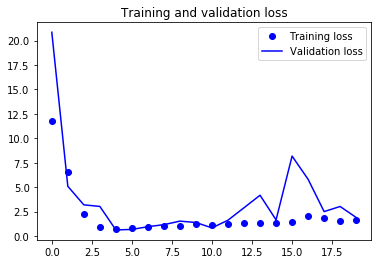

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# save model (if it performs best, I will want to evaluate on test set,
# and in practice would want to use it's predictions)
# serialize model to JSON
model_json = model.to_json()
with open("model_basic.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_basic.h5")

# A first recurrent model

The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence using a recurrent sequence processing model. Instead of the LSTM layer introduced in the previous section, we will use the GRU layer, developed by Cho et al. in 2014.

In [ ]:
start = time.time()

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

end = time.time()
print 'Time elapsed:', end - start

Epoch 1/20
500/500 [==============================] - 3439s 7s/step - loss: 0.3717 - val_loss: 0.4178
Epoch 2/20
500/500 [==============================] - 3439s 7s/step - loss: 0.3636 - val_loss: 0.4047
Epoch 3/20
500/500 [==============================] - 3436s 7s/step - loss: 0.3627 - val_loss: 0.4080
Epoch 4/20
500/500 [==============================] - 3422s 7s/step - loss: 0.3603 - val_loss: 0.4193
Epoch 5/20
500/500 [==============================] - 3431s 7s/step - loss: 0.3582 - val_loss: 0.4062
Epoch 6/20
500/500 [==============================] - 3436s 7s/step - loss: 0.3572 - val_loss: 0.4054
Epoch 7/20
500/500 [==============================] - 3421s 7s/step - loss: 0.3576 - val_loss: 0.3992
Epoch 8/20
500/500 [==============================] - 3443s 7s/step - loss: 0.3563 - val_loss: 0.3990
Epoch 9/20
500/500 [==============================] - 3431s 7s/step - loss: 0.3585 - val_loss: 0.3968
Epoch 10/20
500/500 [==============================] - 3448s 7s/step - loss: 0.357

I interrupted the model here. Not seeing any improvement and it had been running all night (~ 12 hours).

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# save model
model_json = model.to_json()
with open("model_rnn.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_rnn.h5")

# Recurrent dropout to fight overfitting

Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs.

Im going to set far few epochs this time, or I'll be broke.

In [ ]:
start = time.time()

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch= steps_per_epoch,
                              epochs=7,
                              validation_data=val_gen,
                              validation_steps=val_steps)



end = time.time()
print 'Time elapsed:', end - start

Epoch 1/7
510/510 [==============================] - 3656s 7s/step - loss: 0.3809 - val_loss: 0.4040
Epoch 2/7
510/510 [==============================] - 3652s 7s/step - loss: 0.3696 - val_loss: 0.4069
Epoch 3/7
249/510 [=============>................] - ETA: 29:39 - loss: 0.3800

In [31]:
# # save history as a dictionary
# def save_obj(obj, name):
#     with open('histories/' + name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
# save_obj(history.history, 'model_rnn_history')# gave it the wrong name, but leave for now

In [6]:
# load dictionary containing history
# (will need to refined loss and val_loss - see the two lines below)
def load_obj(name ):
    with open('histories/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
model_hist = load_obj('model_rnn_history')   

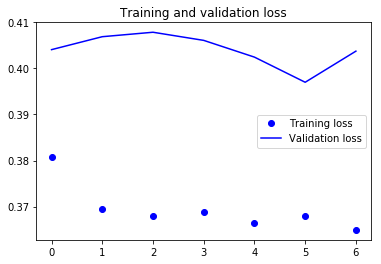

In [7]:
loss = model_hist['loss']
val_loss = model_hist['val_loss']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
print val_loss

[0.4040471062892013, 0.4068554247970934, 0.40782218302289647, 0.4060570528661763, 0.4024261294139756, 0.396972940199905, 0.4037211385590059]


In [ ]:
# save model
model_json = model.to_json()
with open("model_dropout.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_dropout.h5")

# A dropout-regularized, stacked GRU model

In [ ]:
start = time.time()

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

filepath='saved_epochs/stacked-weights-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False)
callbacks_list = [TQDMNotebookCallback(), checkpoint]

history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps, 
                              callbacks=callbacks_list)

end = time.time()
print 'Time elapsed:', end - start

In [ ]:
# # save history 
# def save_obj(obj, name):
#     with open('histories/' + name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
# save_obj(history.history, 'model_stacked_history')

In [3]:
# load dictionary containing history
# (will need to refined loss and val_loss - see the two lines below)
def load_obj(name ):
    with open('histories/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
model_hist = load_obj('model_stacked_history')   

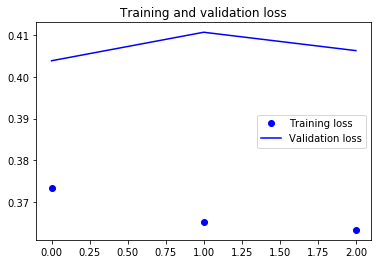

In [4]:
loss = model_hist['loss']
val_loss = model_hist['val_loss']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [5]:
print val_loss

[0.4039141784111659, 0.4107716536080396, 0.4063528112515255]


In [ ]:
# save model
model_json = model.to_json()
with open("saved_models/model_stacked.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("saved_models/model_stacked.h5")

# Run the best performing model on the test set

The different RNN models that I have tried vary little in their performance on the validation set. I will evaluate the dropout model on the test set:

In [23]:
# load json and create model
json_file = open('saved_models/model_dropout.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/model_dropout.h5")
print("Loaded model from disk")

# compile
loaded_model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


In [29]:
score = loaded_model.evaluate_generator(test_gen, steps=test_steps) 
score

[0.3873640545816333, 0.0]

Get predictions (don't need this now, but good to have code):

In [30]:
pred = loaded_model.predict_generator(test_gen, steps=test_steps)
pred

array([[-0.10876478],
       [-0.1357347 ],
       [-0.14838044],
       ...,
       [-0.40960738],
       [-0.43218496],
       [-0.46185914]], dtype=float32)

# Future steps 

## Model tuning

I could try tuning the many different hyperparameters of the model including:

* using a different number of units in each layer
* stacking more layers
* using LSTM layers instead of GRU layers
* using a different form of regularization

## Forecasting for multiple time series

I could forecast for each of the different time series that I am using, that is, calls to each different agency. If I go this route, a [recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting) on web traffic focused on “forecasting the future values of multiple time series, as it has always been one of the most challenging problems in the field.”

## Multi-step forecasting with RNNs

I would like to develop a model to make multi-step forecasts. Forecasting demand for a single 10 minute period in 1 weeks time, for example, probably isn't going to be particualarly helpful for NYC 311. On the other hand, forecasting demand for an hour, several hours, or a whole day might be of great assistance in ensuring that they plan to meet the given demand.

There are at least [four commonly used strategies](https://machinelearningmastery.com/multi-step-time-series-forecasting/) for making multi-step forecasts:


1. Direct Multi-step Forecast Strategy - develop a separate model for each forecast time step. However, having one model for each timestep is an added computational burden. In addition, because separate models are used, it means that there is no opportunity to model the dependencies between the predictions.
2. Recursive multi-step forecast - the recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step. This avoids the need to fit a separate model of each timestep, although the drawback is that it allows prediction errors to accumulate.
3. Direct-Recursive Hybrid Multi-step Forecast Strategies - a separate model can be constructed for each time step to be predicted, but each model may use the predictions made by models at prior time steps as input values. Combining direct and recursive strategies can offer the benefits of both methods, but will still be computationally expensive.
4. Multiple Output Forecast Strategy - develop one model that is capable of predicting the entire forecast sequence. A nice example of a Time Series forecasting model with seq2seq in TensorFlow is [here](https://weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/). It appears that such a seq2seq architecture is [not currently available out of the box in Keras](https://recurrentnull.files.wordpress.com/2017/05/timeseries_prediction_deeplearning.pdf). However, [this package](https://github.com/pipidog/DeepTimeSeries) built on top of Keras says that it offers seq2seq.

Given how long it is taking to fit the models above, (1) and (3) are not practically feasible. 

With respect to (2) and (3) we face two significant problems in seeking to applying recursive partitioning:

* the models above predict ```delay``` timestamps ahead. To apply the recursive strategy, in contrast, we need a prediction (or rather predictions for each feature) for one step ahead.  
* the models above take multiple features as inputs but generate a single prediction. If were to try to use the prior (predicted) step as an input, therefore, we would be missing multiple features from the model and indeed have only a feature (total calls) that was not itself a feature in the original model.

There is currently no out of the box implementaton of (4) in Keras. The [DeepTimeSeries package](https://github.com/pipidog/DeepTimeSeries), built on top of, Keras can fit seq2seq time series models. However, it appears that this package will only generate predictions for subsequent steps; that is, there is again no ```delay``` option. If I want to predict for ten minute intervals a week ahead, this would therefore mean predicting a great many timestamps into the future. It might be possible to "trick" the model my changing the target for the next timestep with the target from 1 week in the future. I'm unsure if this is appropriate, however. Even more problematically, I can't figure out how to fit this model with multiple features at each timestep, although it does look like this should be possible.

I will therefore set aside for now my goal of multi-step forecasting starting several steps ahead, but keep an eye out for future solutions.

# References

In the above analysis I draw very heavily on (and copy and paste from) an example from Francois Chollet (2018) *Deep Learning with Python*, Chatper 6. 